In [ ]:
# GENYZ TEAM
# Aleta Edna Jessalyn 
# Angelina Wahyuni 
# Keisya Andretta
# Infall Syafalni

# reusing the nmos and pmos primitives from gLayout

In [36]:
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

from glayout import MappedPDK, sky130 , gf180
from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../INV"))
from my_INV import inv, add_inv_labels

/headless/conda-env/miniconda3/envs/GLdev/lib/python3.10/site-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 6 in 'CLK_cad$24'
  gdspath = component.write_gds(
2025-09-17 20:54:22.813 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


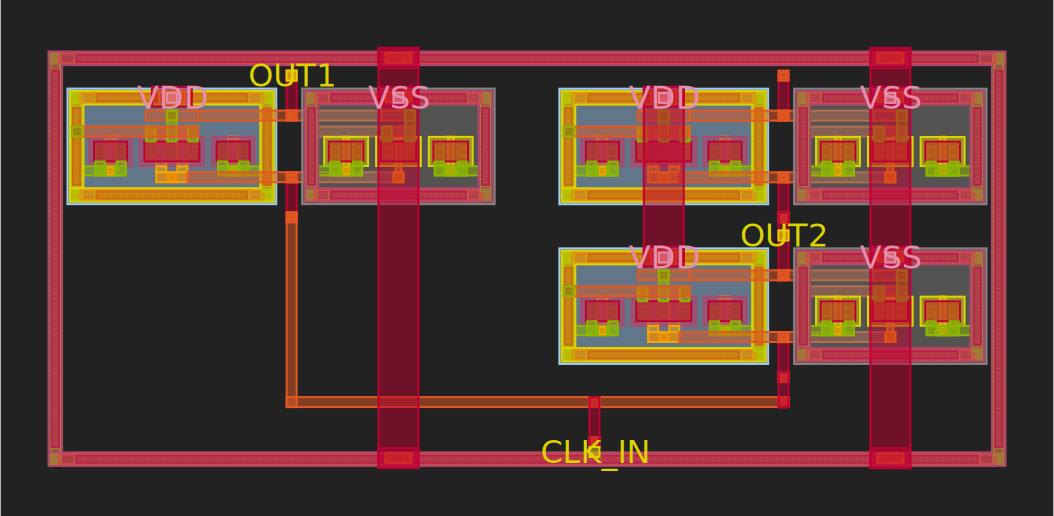

In [40]:
top_level = Component(name="CLK_cad")
pdk= gf180
pdk.activate()

INV1 = inv(pdk)
INV2 = inv(pdk)
INV3 = inv(pdk)

INV1_ref = top_level << INV1
INV2_ref = top_level << INV2
INV3_ref = top_level << INV3

INV1_ref.name = "INV1"
INV2_ref.name = "INV2"
INV3_ref.name = "INV3"

INV2_ref.move(INV1_ref.center).movex(INV1_ref.xmax + 3)
INV3_ref.move(INV1_ref.center).movey(-8).movex(INV1_ref.xmax + 3)

top_level << straight_route(pdk, INV3_ref.ports["OUT_top_met_S"], INV2_ref.ports["IN_top_met_N"])

viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
CLK_IN_start_via = top_level << viam2m3
CLK_IN_end_via = top_level << viam2m3

CLK_IN_start_via.movex(INV1_ref.xmax + 5).movey(INV3_ref.ymin - 1)
CLK_IN_end_via.movex(INV1_ref.xmax + 5).movey(INV3_ref.ymin - 3)

top_level << L_route(pdk, INV1_ref.ports["IN_bottom_met_N"], CLK_IN_start_via.ports["bottom_met_W"])
top_level << L_route(pdk, INV3_ref.ports["IN_top_met_N"], CLK_IN_start_via.ports["bottom_met_E"])
top_level << straight_route(pdk, CLK_IN_start_via.ports["top_met_N"], CLK_IN_end_via.ports["top_met_S"])

tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
shift_amount = -prec_center(top_level.flatten())[0]
shift_amount_y = -prec_center(top_level.flatten())[1]
tring_ref = top_level << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shift_amount_y)

viaarray = via_array(pdk, "met2", "met3", (2,1)) 

top_level.add_ports(CLK_IN_end_via.get_ports_list(), prefix="CLK_IN_")

INV3_NMOS_port_out = INV3_ref.ports["N_tie_N_top_met_N"]
INV1_NMOS_port_out = INV1_ref.ports["N_tie_N_top_met_N"]
INV2_NMOS_port_out = INV2_ref.ports["N_tie_N_top_met_N"]

INV3_PMOS_port_out = INV3_ref.ports["P_tie_N_top_met_N"]
INV1_PMOS_port_out = INV1_ref.ports["P_tie_N_top_met_N"]
INV2_PMOS_port_out = INV2_ref.ports["P_tie_N_top_met_N"]

Via_Tapring_1 = top_level << viaarray
Via_Tapring_2 = top_level << viaarray
Via_Tapring_3 = top_level << viaarray
Via_Tapring_4 = top_level << viaarray

Via_VDD_2 = top_level << viaarray
Via_VDD_3 = top_level << viaarray
Via_VDD_4 = top_level << viaarray

Via_VSS_2 = top_level << viaarray
Via_VSS_3 = top_level << viaarray
Via_VSS_4 = top_level << viaarray

Via_VDD_2.move(INV1_PMOS_port_out.center).movey(-0.2)
Via_VDD_3.move(INV2_PMOS_port_out.center).movey(-0.2)
Via_VDD_4.move(INV3_PMOS_port_out.center).movey(-0.2)

Via_VSS_2.move(INV1_NMOS_port_out.center).movey(-0.2)
Via_VSS_3.move(INV2_NMOS_port_out.center).movey(-0.2)
Via_VSS_4.move(INV3_NMOS_port_out.center).movey(-0.2)

Via_Tapring_1.move(INV2_NMOS_port_out.center).movey( + 1.75)
Via_Tapring_2.move(INV1_NMOS_port_out.center).movey(+ 1.75)
Via_Tapring_3.move(INV1_NMOS_port_out.center).movey(-18.3)
Via_Tapring_4.move(INV3_NMOS_port_out.center).movey(-10.3)

top_level << straight_route(pdk, Via_Tapring_1.ports["top_met_N"], Via_Tapring_4.ports["top_met_S"])
top_level << straight_route(pdk, Via_Tapring_2.ports["top_met_N"], Via_Tapring_3.ports["top_met_S"])
top_level << straight_route(pdk, Via_VDD_3.ports["top_met_N"], Via_VDD_4.ports["top_met_S"])

INV1_port_out = INV1_ref.ports["OUT_top_met_N"]
INV3_port_out = INV3_ref.ports["OUT_top_met_N"]
top_level.add_port(name="OUT1_", port=INV1_port_out)
top_level.add_port(name="OUT2_", port=INV3_port_out)

top_level.add_port(name="P_INV3_", port=INV3_PMOS_port_out)
top_level.add_port(name="P_INV1_", port=INV1_PMOS_port_out)
top_level.add_port(name="P_INV2_", port=INV2_PMOS_port_out)

top_level.add_port(name="N_INV3_", port=INV3_NMOS_port_out)
top_level.add_port(name="N_INV1_", port=INV1_NMOS_port_out)
top_level.add_port(name="N_INV2_", port=INV2_NMOS_port_out)


component = component_snap_to_grid(rename_ports_by_orientation(top_level))

psize=(0.5,0.5)
# list that will contain all port/comp info
move_info = list()
# create labels and append to info list

inputplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputplabel.add_label(text="CLK_IN",layer=pdk.get_glayer("met3_pin"))
move_info.append((inputplabel,component.ports["CLK_IN_top_met_S"], None))

output1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
output1label.add_label(text="OUT1",layer=pdk.get_glayer("met3_pin"))
move_info.append((output1label,component.ports["OUT1_N"],None))
output2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
output2label.add_label(text="OUT2",layer=pdk.get_glayer("met3_pin"))
move_info.append((output2label,component.ports["OUT2_N"],None))

# VSS
vsslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met2_label"))
move_info.append((vsslabel,component.ports["N_INV1_N"],None))
move_info.append((vsslabel,component.ports["N_INV2_N"],None))
move_info.append((vsslabel,component.ports["N_INV3_N"],None))

#suply
vddlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met2_label"))
move_info.append((vddlabel,component.ports["P_INV3_N"],None))
move_info.append((vddlabel,component.ports["P_INV2_N"],None))
move_info.append((vddlabel,component.ports["P_INV1_N"],None))


for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)

comps = top_level.flatten()
comps.name="CLK"

top_level.show()
display_component(top_level, scale = 2,path="../../")

In [42]:
inv_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../INV"))
from my_INV import inv, add_inv_labels

def add_clkcs1_labels(
    clkcs_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    
    clkcs_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    inputplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputplabel.add_label(text="CLK_IN",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputplabel,Component.ports["CLK_IN_top_met_S"], None))

    output1label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    output1label.add_label(text="OUT1",layer=pdk.get_glayer("met3_pin"))
    move_info.append((output1label,Component.ports["OUT1_N"],None))
    output2label = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    output2label.add_label(text="OUT2",layer=pdk.get_glayer("met3_pin"))
    move_info.append((output2label,Component.ports["OUT2_N"],None))

    # VSS
    vsslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met2_label"))
    move_info.append((vsslabel,Component.ports["N_INV1_N"],None))
    move_info.append((vsslabel,Component.ports["N_INV2_N"],None))
    move_info.append((vsslabel,Component.ports["N_INV3_N"],None))
    
    #suply
    vddlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met2_label"))
    move_info.append((vddlabel,Component.ports["P_INV3_N"],None))
    move_info.append((vddlabel,Component.ports["P_INV2_N"],None))
    move_info.append((vddlabel,Component.ports["P_INV1_N"],None))
    
    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            clkcs_in.add(compref)
    
    return clkcs_in.flatten()


def clkcs1(
        pdk: MappedPDK
        ) -> Component:

    pdk.activate()
    
    top_level = Component(name="CLK_CS")

    INV1 = inv(pdk)
    INV2 = inv(pdk)
    INV3 = inv(pdk)
    
    INV1_ref = top_level << INV1
    INV2_ref = top_level << INV2
    INV3_ref = top_level << INV3
    
    INV1_ref.name = "INV1"
    INV2_ref.name = "INV2"
    INV3_ref.name = "INV3"
    
    INV2_ref.move(INV1_ref.center).movex(INV1_ref.xmax + 3)
    INV3_ref.move(INV1_ref.center).movey(-8).movex(INV1_ref.xmax + 3)
    
    top_level << straight_route(pdk, INV3_ref.ports["OUT_top_met_S"], INV2_ref.ports["IN_top_met_N"])
    
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
    CLK_IN_start_via = top_level << viam2m3
    CLK_IN_end_via = top_level << viam2m3
    
    CLK_IN_start_via.movex(INV1_ref.xmax + 5).movey(INV3_ref.ymin - 1)
    CLK_IN_end_via.movex(INV1_ref.xmax + 5).movey(INV3_ref.ymin - 3)
    
    top_level << L_route(pdk, INV1_ref.ports["IN_bottom_met_N"], CLK_IN_start_via.ports["bottom_met_W"])
    top_level << L_route(pdk, INV3_ref.ports["IN_top_met_N"], CLK_IN_start_via.ports["bottom_met_E"])
    top_level << straight_route(pdk, CLK_IN_start_via.ports["top_met_N"], CLK_IN_end_via.ports["top_met_S"])

    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
    shift_amount = -prec_center(top_level.flatten())[0]
    shift_amount_y = -prec_center(top_level.flatten())[1]
    tring_ref = top_level << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shift_amount_y)

    viaarray = via_array(pdk, "met2", "met3", (2,1)) 
    
    top_level.add_ports(CLK_IN_end_via.get_ports_list(), prefix="CLK_IN_")

    INV3_NMOS_port_out = INV3_ref.ports["N_tie_N_top_met_N"]
    INV1_NMOS_port_out = INV1_ref.ports["N_tie_N_top_met_N"]
    INV2_NMOS_port_out = INV2_ref.ports["N_tie_N_top_met_N"]

    INV3_PMOS_port_out = INV3_ref.ports["P_tie_N_top_met_N"]
    INV1_PMOS_port_out = INV1_ref.ports["P_tie_N_top_met_N"]
    INV2_PMOS_port_out = INV2_ref.ports["P_tie_N_top_met_N"]

    Via_Tapring_1 = top_level << viaarray
    Via_Tapring_2 = top_level << viaarray
    Via_Tapring_3 = top_level << viaarray
    Via_Tapring_4 = top_level << viaarray

    Via_VDD_2 = top_level << viaarray
    Via_VDD_3 = top_level << viaarray
    Via_VDD_4 = top_level << viaarray

    Via_VSS_2 = top_level << viaarray
    Via_VSS_3 = top_level << viaarray
    Via_VSS_4 = top_level << viaarray

    Via_VDD_2.move(INV1_PMOS_port_out.center).movey(-0.2)
    Via_VDD_3.move(INV2_PMOS_port_out.center).movey(-0.2)
    Via_VDD_4.move(INV3_PMOS_port_out.center).movey(-0.2)

    Via_VSS_2.move(INV1_NMOS_port_out.center).movey(-0.2)
    Via_VSS_3.move(INV2_NMOS_port_out.center).movey(-0.2)
    Via_VSS_4.move(INV3_NMOS_port_out.center).movey(-0.2)

    Via_Tapring_1.move(INV2_NMOS_port_out.center).movey( + 1.75)
    Via_Tapring_2.move(INV1_NMOS_port_out.center).movey(+ 1.75)
    Via_Tapring_3.move(INV1_NMOS_port_out.center).movey(-18.3)
    Via_Tapring_4.move(INV3_NMOS_port_out.center).movey(-10.3)

    top_level << straight_route(pdk, Via_Tapring_1.ports["top_met_N"], Via_Tapring_4.ports["top_met_S"])
    top_level << straight_route(pdk, Via_Tapring_2.ports["top_met_N"], Via_Tapring_3.ports["top_met_S"])
    top_level << straight_route(pdk, Via_VDD_3.ports["top_met_N"], Via_VDD_4.ports["top_met_S"])

    INV1_port_out = INV1_ref.ports["OUT_top_met_N"]
    INV3_port_out = INV3_ref.ports["OUT_top_met_N"]
    top_level.add_port(name="OUT1_", port=INV1_port_out)
    top_level.add_port(name="OUT2_", port=INV3_port_out)

    top_level.add_port(name="P_INV3_", port=INV3_PMOS_port_out)
    top_level.add_port(name="P_INV1_", port=INV1_PMOS_port_out)
    top_level.add_port(name="P_INV2_", port=INV2_PMOS_port_out)

    top_level.add_port(name="N_INV3_", port=INV3_NMOS_port_out)
    top_level.add_port(name="N_INV1_", port=INV1_NMOS_port_out)
    top_level.add_port(name="N_INV2_", port=INV2_NMOS_port_out)
 
    return component_snap_to_grid(rename_ports_by_orientation(top_level))

if __name__ == "__main__":
\tcomp = clkcs1(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_clkcs1_labels(comp, gf180)\n
\tcomp.name = "clkcs1"\n
\tcomp.write_gds('out_clkcs1.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "clkcs1")\n
\tdrc_result = gf180.drc(comp)\n
"""

clk_init_string = """
###Glayout clkcs Cell.


from .my_CLK_CS_CAD import clkcs1, add_clkcs1_labels

__all__ = [
    'clkcs1',
    'add_clkcs1_labels',
] 
"""

directory = "../../CLK_CS_CAD/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_CLK_CS_CAD.py", "w") as file:
    file.write(inv_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(clk_init_string)